# Spatial Autocorrelation

This tutorial explores spatial autocorrelation using open source GIS libraries in the `pysal` family. Broadly, autocorrelation refers to the idea that a variable is correlated _within itself_, in this case because their is some underlying spatial clustering structure within the data. For each of the tests explored here, the null hypothesis is that the data are spatially random while the alternative hypotheses data are autocorrelated to some degree.

We will test these patterns with several versions of a Moran's I test, a common spatial statistic for assessing autocorrelation:
- Global Moran's I tests whether there is some degree of autocorrelation within a variable anywhere in the entire dataset. It tells you if there is an underlying spatial structure to the data.
- Local Moran's I measures the degree of autocorrelation for each individual observation in the dataset. It tells you where the underlying spatial structure of the data is located and how it varies across the geography of the data.
- Bivariate Moran's I assesses two variables. It measures the degree of autocorrelation in each variable, and then also tests whether the two variables are correlated.
<br>
<br>

## Learning outcomes
By the end of the tutorial, you should be able to:
1) Interpret the overall spatial structure of data with global Moran's I
2) Interpret the local variation in spatial structure with local Moran's I
3) Apply open source GIS tools to manage spatial data and analyze spatial statistics.
<br>
<br>

The tutorial is based on [Exploratory Analysis of Spatial Data: Spatial Autocorrelation](https://pysal.org/esda/notebooks/spatial_autocorrelation_for_areal_unit_data.html#) by Levi Wolf and Serge Rey. I have marked it up to resolve some replication errors, to shorten for topics of relevance to INFO 612 students, and to explain where relevant.

## Set up
To replicate this workflow, load the notebook in whatever platform you want to use (e.g. add it to a project in ArcGIS Pro, open it in Jupyter Notebooks on your local machine, or open it in a cloud environment like [ArcGIS Online](https://www.arcgis.com/index.html) or [Google Colab](https://colab.research.google.com/)).

You might need to install some of the libraries used in the workflow. If that's the case, you can use the `! pip install` notation described below.

In [ ]:
# load the necessary libraries
import geopandas    ## for managing spatial data
import esda  # for exploratory spatial data analysis
import libpysal as lps   ## for spatial analysis, and note I'm using an alias for simplicity
import mapclassify ## for defining classification schemes
import matplotlib.pyplot as plt ## for basic data visualizations, anot alias
import numpy  ## for math functions that some of the other libraries use
import pandas ## for managing tabular data
import seaborn ## for more specialized data visualizations
import warnings ## for suppressing warnings

# and we'll also use more specific classes from these libraries
from geopandas import GeoDataFrame ## for managing spatial data
from matplotlib import colors   ## for a director of colors to use in visualizations
from shapely.geometry import Point ## for visualizing spatial data

You may get an error stating that some of these libraries are missing. If you do, you can install them using the format below. After installing, then run the import code cell again.

In [ ]:
# You may first have to install some of these libraries. You can do this within a notebook using this notation:
! pip install esda
! pip install mapclassify

## Loading data
This uses two layers on housing in Berlin, borrowing from the aforementioned [spatial autocorrelation with `esda` tutorial](https://pysal.org/esda/notebooks/spatial_autocorrelation_for_areal_unit_data.html#). One is a `csv` containing web scraped data from AirBNB listings. The other is a `geojson` of neighborhood boundaries. We'll load both from the source GitHub repository.

In [ ]:
# Load the geojson data directly from GitHub using this notation
boundaries = geopandas.read_file("https://raw.githubusercontent.com/ljwolf/geopython/master/data/berlin-neighbourhoods.geojson")

# and view the data
boundaries

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.3963, 13.70926 52...."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.4085, 13.73773 52...."
...,...,...,...
135,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52..."
136,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52..."
137,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52..."
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52..."


In [ ]:
# Similar procedure here for CSV data from GitHub. Though note that pandas cannot directly take the URL as a parameter.
url = "https://raw.githubusercontent.com/ljwolf/geopython/master/data/berlin-listings.csv.gz"
df = pandas.read_csv(url)

# note I called this `df`, an abbreviation for 'dataframe' commonly used in Python.
# there's nothing special about that notation. It's just a common convention.
df

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad für jedermann,"Meine Unterkunft ist gut für paare, alleinreis...",NaN,"Meine Unterkunft ist gut für paare, alleinreis...",none,...,10.0,f,NaN,NaN,t,flexible,f,f,3,2.00
1,1,17227881,https://www.airbnb.com/rooms/17227881,20170507222235,2017-05-08,Modernes Zimmer in Berlin Pankow,Es ist ein schönes gepflegtes und modernes Zim...,Das Haus befindet sich direkt vor eine Tram Ha...,Es ist ein schönes gepflegtes und modernes Zim...,none,...,10.0,f,NaN,NaN,t,flexible,f,f,1,1.29
2,2,1153584,https://www.airbnb.com/rooms/1153584,20170507222235,2017-05-08,Gästezimmer Berlin-Pankow,Unser Gästezimmer befindet sich im Dachgeschos...,"Wenn Ihr eine anspruchsvolles Ambiente sucht, ...",Unser Gästezimmer befindet sich im Dachgeschos...,none,...,10.0,f,NaN,NaN,f,flexible,f,f,1,1.27
3,3,7832750,https://www.airbnb.com/rooms/7832750,20170507222235,2017-05-08,Sonniges Doppelzimmer+Nice Price!,Welcome! Hier vermiete ich ein kleines Wohlfüh...,Die Wohnung ist durch Ihre Lage sehr schön hel...,Welcome! Hier vermiete ich ein kleines Wohlfüh...,none,...,10.0,f,NaN,NaN,t,flexible,f,f,1,5.43
4,4,11634962,https://www.airbnb.com/rooms/11634962,20170507222235,2017-05-08,Room for womens in Pankow 30 min from the city,Gemütliches Zimmer im ruhigen Teil von Berlin....,"Es handelt sich um ein großes, gemütliches Zim...",Gemütliches Zimmer im ruhigen Teil von Berlin....,none,...,9.0,f,NaN,NaN,f,flexible,f,f,1,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20048,20571,17511241,https://www.airbnb.com/rooms/17511241,20170507222235,2017-05-08,Private nice room near Metro U8 and Tegel Airport,Very tidy and simple flat in white town. It's ...,NaN,Very tidy and simple flat in white town. It's ...,none,...,9.0,f,NaN,NaN,t,moderate,f,f,1,6.89
20049,20572,597413,https://www.airbnb.com/rooms/597413,20170507222235,2017-05-08,Cozy flat,"Schlafplatz für 2 Personen auf der Couch, sehr...",We have a sunny room in Berlin Reinickendorf n...,We have a sunny room in Berlin Reinickendorf n...,none,...,9.0,f,NaN,NaN,f,strict,f,f,3,0.20
20050,20573,4712991,https://www.airbnb.com/rooms/4712991,20170507222235,2017-05-08,Loft im grünen Norden Berlins,Willkommen in unserem Loft unter dem Dach. Zu ...,Das Apartment ist hell und freundlich geschnit...,Willkommen in unserem Loft unter dem Dach. Zu ...,none,...,9.0,f,NaN,NaN,f,moderate,f,f,2,0.73
20051,20574,13054913,https://www.airbnb.com/rooms/13054913,20170507222235,2017-05-08,"Nice, modern, quite single room in the green N...",Meine Unterkunft liegt in einem Mehrfamilienha...,My apartment is situated in the northern outsk...,My apartment is situated in the northern outsk...,none,...,10.0,f,NaN,NaN,f,flexible,f,f,1,0.77


In [ ]:
# now we'll define the geometry and projection for that csv
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude, strict=True)]
crs = 4326  # this is an EPSG projection code

# and transform it into a spatial data frame
listings = GeoDataFrame(df, crs=crs, geometry=geometry)
listings

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad für jedermann,"Meine Unterkunft ist gut für paare, alleinreis...",NaN,"Meine Unterkunft ist gut für paare, alleinreis...",none,...,f,NaN,NaN,t,flexible,f,f,3,2.00,POINT (13.39609 52.58331)
1,1,17227881,https://www.airbnb.com/rooms/17227881,20170507222235,2017-05-08,Modernes Zimmer in Berlin Pankow,Es ist ein schönes gepflegtes und modernes Zim...,Das Haus befindet sich direkt vor eine Tram Ha...,Es ist ein schönes gepflegtes und modernes Zim...,none,...,f,NaN,NaN,t,flexible,f,f,1,1.29,POINT (13.39858 52.57642)
2,2,1153584,https://www.airbnb.com/rooms/1153584,20170507222235,2017-05-08,Gästezimmer Berlin-Pankow,Unser Gästezimmer befindet sich im Dachgeschos...,"Wenn Ihr eine anspruchsvolles Ambiente sucht, ...",Unser Gästezimmer befindet sich im Dachgeschos...,none,...,f,NaN,NaN,f,flexible,f,f,1,1.27,POINT (13.39926 52.58922)
3,3,7832750,https://www.airbnb.com/rooms/7832750,20170507222235,2017-05-08,Sonniges Doppelzimmer+Nice Price!,Welcome! Hier vermiete ich ein kleines Wohlfüh...,Die Wohnung ist durch Ihre Lage sehr schön hel...,Welcome! Hier vermiete ich ein kleines Wohlfüh...,none,...,f,NaN,NaN,t,flexible,f,f,1,5.43,POINT (13.39558 52.58231)
4,4,11634962,https://www.airbnb.com/rooms/11634962,20170507222235,2017-05-08,Room for womens in Pankow 30 min from the city,Gemütliches Zimmer im ruhigen Teil von Berlin....,"Es handelt sich um ein großes, gemütliches Zim...",Gemütliches Zimmer im ruhigen Teil von Berlin....,none,...,f,NaN,NaN,f,flexible,f,f,1,1.45,POINT (13.39366 52.58375)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20048,20571,17511241,https://www.airbnb.com/rooms/17511241,20170507222235,2017-05-08,Private nice room near Metro U8 and Tegel Airport,Very tidy and simple flat in white town. It's ...,NaN,Very tidy and simple flat in white town. It's ...,none,...,f,NaN,NaN,t,moderate,f,f,1,6.89,POINT (13.35246 52.56949)
20049,20572,597413,https://www.airbnb.com/rooms/597413,20170507222235,2017-05-08,Cozy flat,"Schlafplatz für 2 Personen auf der Couch, sehr...",We have a sunny room in Berlin Reinickendorf n...,We have a sunny room in Berlin Reinickendorf n...,none,...,f,NaN,NaN,f,strict,f,f,3,0.20,POINT (13.35545 52.57206)
20050,20573,4712991,https://www.airbnb.com/rooms/4712991,20170507222235,2017-05-08,Loft im grünen Norden Berlins,Willkommen in unserem Loft unter dem Dach. Zu ...,Das Apartment ist hell und freundlich geschnit...,Willkommen in unserem Loft unter dem Dach. Zu ...,none,...,f,NaN,NaN,f,moderate,f,f,2,0.73,POINT (13.32764 52.6024)
20051,20574,13054913,https://www.airbnb.com/rooms/13054913,20170507222235,2017-05-08,"Nice, modern, quite single room in the green N...",Meine Unterkunft liegt in einem Mehrfamilienha...,My apartment is situated in the northern outsk...,My apartment is situated in the northern outsk...,none,...,f,NaN,NaN,f,flexible,f,f,1,0.77,POINT (13.33678 52.60993)


# Exploring the data
We'll start by exploring median AirBNB prices in Berlin. This exploration will demonstrate that there are visual variations in the price, but we'll need further statistical testing to assess if those visual patterns are statsitically significant.  


In [ ]:
# create a price variable
listings["price"] = listings["price"].astype("float32")

# create a new spatial data frame by joining boundaries to listings data
# note I called it 'gdf' for 'geospatial data frame'. Again, nothing special here. It's just a common convention.
spatialjoin = geopandas.sjoin(
    left_df=boundaries,
    right_df=listings,
    how="inner",
    predicate="intersects",
    lsuffix="left",
    rsuffix="right"
)

# view results
spatialjoin

,neighbourhood_left,neighbourhood_group,geometry,index_right,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",41,43,4604780,https://www.airbnb.com/rooms/4604780,20170507222235,2017-05-08,Ruhig im Grünen-schnell in der City,...,9.0,f,NaN,NaN,f,flexible,f,f,1,0.85
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",35,35,16153479,https://www.airbnb.com/rooms/16153479,20170507222235,2017-05-08,Gemütliches Apartment in Pankow,...,8.0,f,NaN,NaN,t,strict,f,f,1,1.64
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",30,30,16560578,https://www.airbnb.com/rooms/16560578,20170507222235,2017-05-08,Nice Place,...,NaN,f,NaN,NaN,t,flexible,f,f,1,NaN
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",3,3,7832750,https://www.airbnb.com/rooms/7832750,20170507222235,2017-05-08,Sonniges Doppelzimmer+Nice Price!,...,10.0,f,NaN,NaN,t,flexible,f,f,1,5.43
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",16,16,16682014,https://www.airbnb.com/rooms/16682014,20170507222235,2017-05-08,Zuhause im Glück,...,NaN,f,NaN,NaN,t,strict,f,f,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52...",20016,20537,8528508,https://www.airbnb.com/rooms/8528508,20170507222235,2017-05-08,Schönes Zimmer nähe Flughafen Tegel,...,10.0,f,NaN,NaN,f,moderate,f,f,1,0.27
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52...",20033,20555,17453626,https://www.airbnb.com/rooms/17453626,20170507222235,2017-05-08,Cosy bright colourful apartment,...,NaN,f,NaN,NaN,f,flexible,f,f,1,NaN
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52...",20024,20546,15777459,https://www.airbnb.com/rooms/15777459,20170507222235,2017-05-08,Cozy 31m² studio apartment in Berlin-Reinicken...,...,10.0,f,NaN,NaN,f,strict,f,f,1,0.54
139,MV 2,Reinickendorf,"MULTIPOLYGON (((13.34846 52.60664, 13.34911 52...",20050,20573,4712991,https://www.airbnb.com/rooms/4712991,20170507222235,2017-05-08,Loft im grünen Norden Berlins,...,9.0,f,NaN,NaN,f,moderate,f,f,2,0.73


In [ ]:
# view a summary price by neighborhood
mean_price_gb = spatialjoin["price"].groupby([spatialjoin["neighbourhood_group"]]).mean()
mean_price_gb

,price
neighbourhood_group,
Charlottenburg-Wilm.,58.556408
Friedrichshain-Kreuzberg,55.492809
Lichtenberg,44.584270
Marzahn - Hellersdorf,54.246754
Mitte,60.387890
Neukölln,45.135948
Pankow,60.282516
Reinickendorf,43.682465
Spandau,48.236561


In [ ]:
# join this back to the original boundary data
gdf = boundaries.join(mean_price_gb, on="neighbourhood_group")
gdf.rename(columns={"price": "price_mean"}, inplace=True)
gdf

,neighbourhood,neighbourhood_group,geometry,price_mean
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",60.282516
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",60.282516
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...",58.556408
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.3963, 13.70926 52....",51.222004
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.4085, 13.73773 52....",51.222004
...,...,...,...,...
135,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52...",54.246754
136,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52...",54.246754
137,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52...",43.682465
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52...",43.682465


In [ ]:
# and we have to deal with some null values
pandas.isnull(gdf["price_mean"]).sum()

# we'll replace the nulls with the city-wide mean. That's one of many possible ways to deal with this. Another option would be to drop the nulls.
gdf["price_mean"] = gdf["price_mean"].fillna(gdf["price_mean"].mean())

<Axes: >

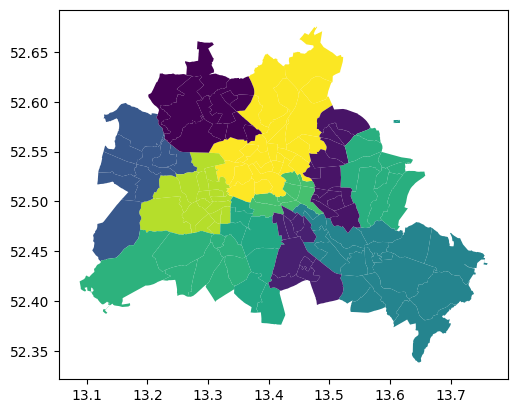

In [ ]:
# map the result
gdf.plot(column="price_mean")

<Axes: >

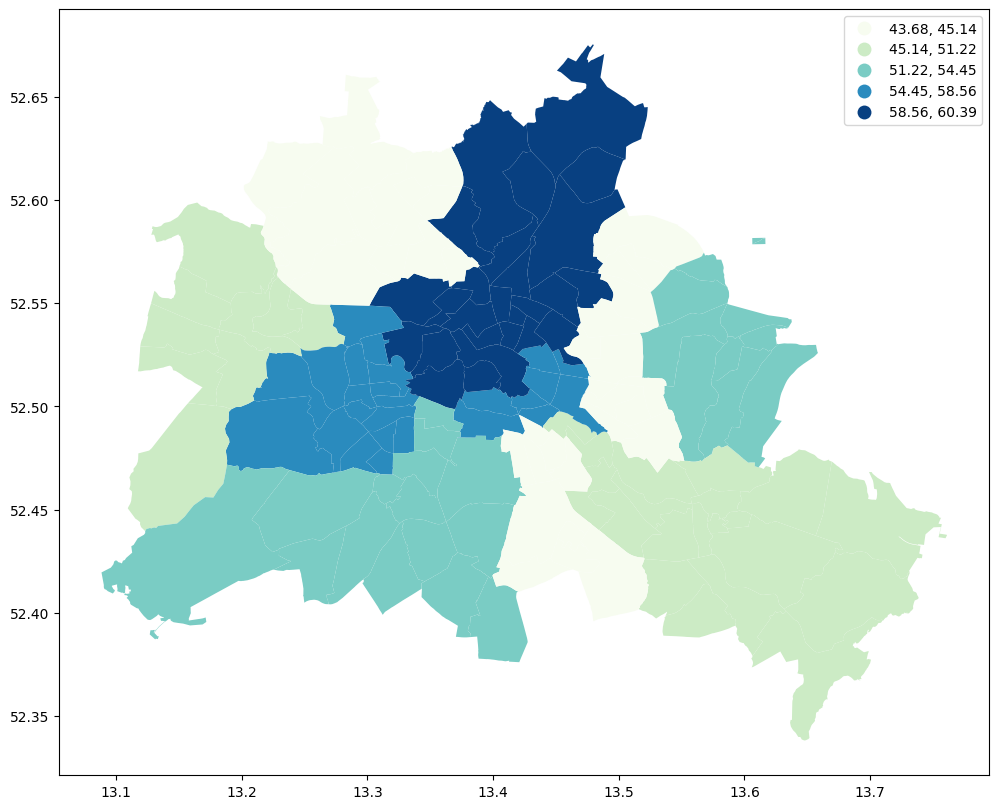

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"aspect": "equal"})
gdf.plot(column="price_mean", scheme="Quantiles", k=5, cmap="GnBu", legend=True, ax=ax)

<Axes: >

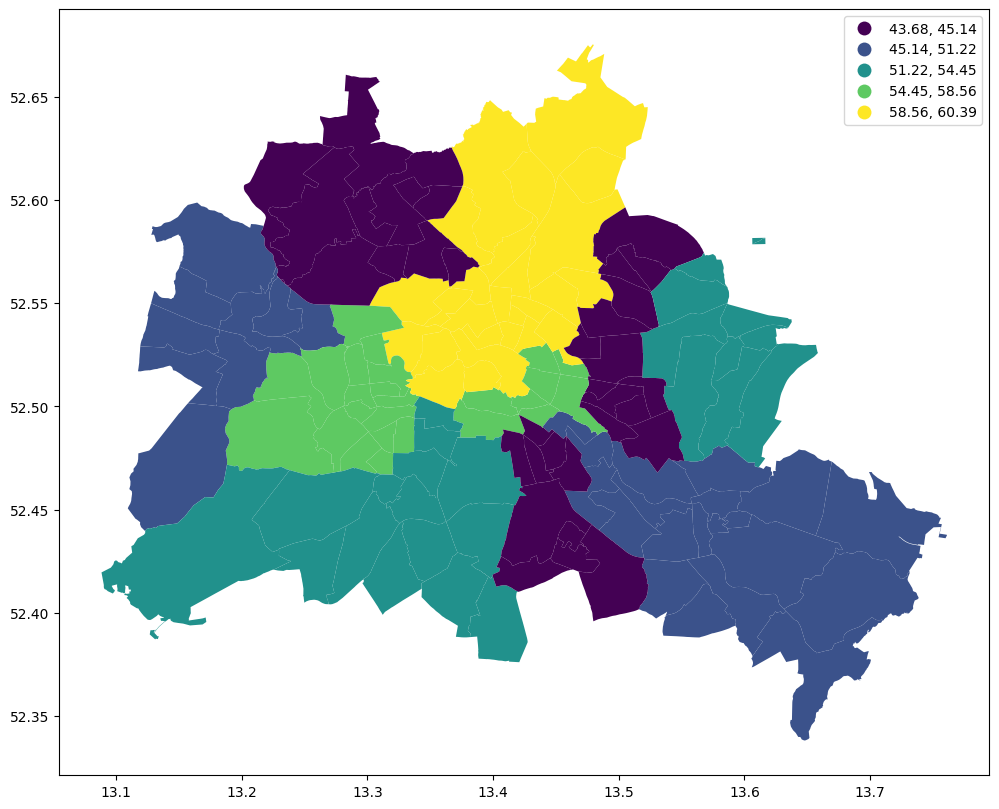

In [ ]:
# now reclassify the choropleth into quantiles
# define a legend
fig, ax = plt.subplots(figsize=(12, 10),
                        subplot_kw={"aspect": "equal"}
                        )

# create the new plot
gdf.plot(column="price_mean",
         scheme="Quantiles",
         k=5,
         cmap="viridis",
         legend=True,
         ax=ax
         )

# Global Moran's I
In this segment, we'll calculate and interpret the global Moran's I. This is a global spatial statistic, meaning that it tests for the presence of a spatial structure somewhere in the dataset. But it will not tell you anything about what the structure is or where it might be found in the map.

The steps are to:
1) Define a spatial weights matrix. This defines the neighborhood search radius to use in subsequent analysis. We'll use a queen contiguity matrix, which searches for neigbors that are contiguous to each feature, in any possible direction (like how a queen can move across a chess board -- contigiously, in any direction).
2) Calculate attribute similarities across each pair of observations -- in this case using a spatial lag metric. The spatial lag is the weighted average of the variable for each feature's neighborhood search radius (the radius -- and the weight used in averaging -- is from the weights matrix).
3) Calculate and test the global Moran's I metric.


In [ ]:
# create a spatial weights matrix to assess spatial similarity
df = gdf # this needs a data frame, non-spatial

# use a queen contiguity for the matrix
weights = lps.weights.Queen.from_dataframe(df, use_index=False, silence_warnings=True)

# tranform the weights so they are standardized by row
# that is, the weights for each row will sum to 1
weights.transform = "r"
weights

In [ ]:
# view attribute similarity using a spatial lag metric
y = df["price_mean"]

ylag = lps.weights.lag_spatial(w=weights, y=y)
ylag

array([56.9625061 , 60.28251648, 56.37749926, 51.22200394, 51.22200394,
       50.52180099, 43.6824646 , 45.63422012, 52.65491422, 60.28251648,
       53.64180374, 52.73586273, 52.73586273, 56.47182541, 47.83247757,
       58.58870177, 60.33520317, 59.60296903, 60.38788986, 60.02159348,
       51.80624199, 57.94034958, 52.84482813, 53.40314266, 57.90522512,
       60.28251648, 60.28251648, 55.79730334, 56.79401737, 50.81182589,
       59.01427841, 60.29756982, 60.28251648, 50.86356888, 60.3220315 ,
       60.28251648, 55.48057556, 54.42881557, 60.32466583, 59.50179418,
       54.42846909, 58.55640793, 58.55640793, 57.73426285, 57.47818544,
       57.74774106, 56.13040733, 48.23656082, 48.23656082, 53.74621709,
       55.11957245, 45.95951271, 51.67650986, 54.1985906 , 51.45368042,
       52.36880302, 54.44568253, 54.44568253, 50.84825389, 56.50104523,
       53.92108345, 55.9956289 , 50.49590378, 49.14499828, 48.61369433,
       49.70049   , 49.32550866, 51.22200394, 51.22200394, 47.80

Now we'll visualize the difference between the variable and it's lagged form. We'll create two maps side by side. The original variable displays on the left, showing the observed geography. The lagged variable displays on the right, showing the potential for an underlying spatial structure.

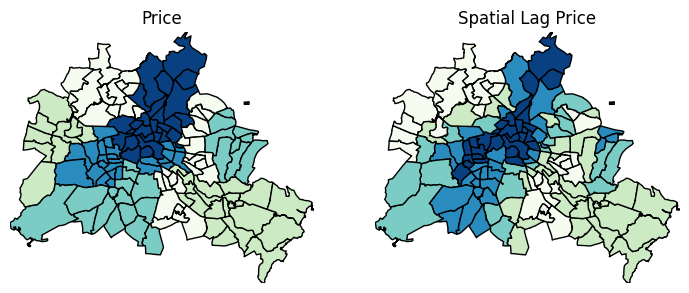

In [ ]:
# visualize the difference between price and lagged price
df["lag_price_mean"] = ylag
f, ax = plt.subplots(1, 2, figsize=(2.16 * 4, 4))
df.plot(
    column="price_mean", ax=ax[0], edgecolor="k", scheme="quantiles", k=5, cmap="GnBu"
)
ax[0].axis(df.total_bounds[numpy.asarray([0, 2, 1, 3])])
ax[0].set_title("Price")
df.plot(
    column="lag_price_mean",
    ax=ax[1],
    edgecolor="k",
    scheme="quantiles",
    cmap="GnBu",
    k=5,
)
ax[1].axis(df.total_bounds[numpy.asarray([0, 2, 1, 3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

Now we'll calculate the global Moran's I. This returns a single number indicating whether there is or is not an underlying spatial structure in the data.

> H0: The data are spatially random.

> HA: There is an underlying spatial clustering in the data.

The metric will range from -1 to 1, with 0 indicating spatial randomness. Negative numbers indicate negative spatial autocorrelation; positive numbers indicate positive spatial autocorrelation. The magnitude of the number indicates the relative strength of the spatial pattern.

In [ ]:
# define a random seed to simulate pseudo p-values
numpy.random.seed(12345)

In [ ]:
# calculate the global Moran's I
mi = esda.moran.Moran(y=df["price_mean"],
                      w=weights)

# show results
print(f"Moran's I: {mi.I}")
print(f"pseudo p-value: {mi.p_sim}")

Moran's I: 0.6563069331329718
pseudo p-value: 0.001


We'll also generate a large number of simulations of Moran's I calculations for the artificial data created by the random seed, data which are spatially random. We can then compare our actual value to the simulations, to test whether our observed value of I is statistically significant. This will give us a 'pseudo p-value' that can be interpreted like p-values in other statistical tests (that is, p = the probability of a false positive).

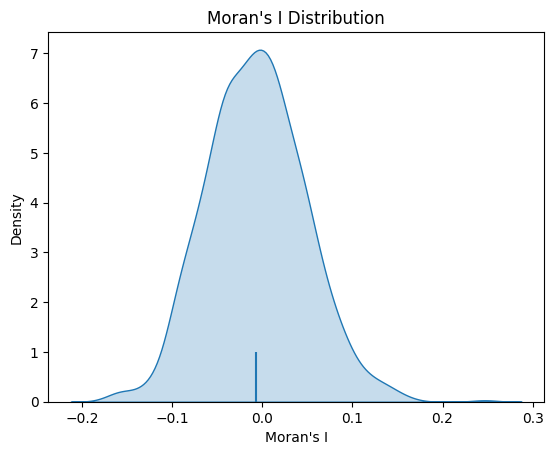

In [ ]:
# this is the distribution of simulated I values
seaborn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.EI, 0, 1)
plt.xlabel("Moran's I")
plt.ylabel("Density")
plt.title("Moran's I Distribution")
plt.show()

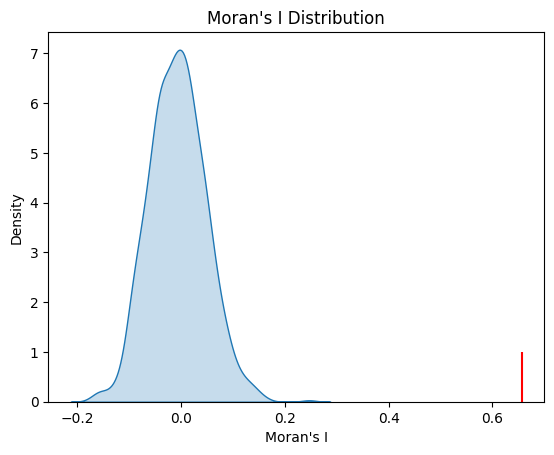

In [ ]:
# and this adds the observed I value to it
seaborn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.I, 0, 1, color="r")  # adds the observed mi.I
plt.xlabel("Moran's I")
plt.ylabel("Density")
plt.title("Moran's I Distribution")
plt.show()

# Local Moran's I
Next we'll calculate the local Moran's I scores for each observation in the dataaset. In the global test we determined that there is indeed an underlying sptial structure. Now we'll use the local metric to evaluate where that structure exists and the spatially varying degree of statistical significance.

In [ ]:
# again, we'll set the matrix
weights.transform = "r"

# and generate a random seed
numpy.random.seed(12345)

Now we'll also define a local spatial lag metric to visualize how it compares against the global metric. The spatial lag is the weighted average of the variable's values in the neighboring features. The neighbors are defined by the weights matrix -- in this case contiguously in any direction, since we're using a queen contiquity matrix. And the average is based on the specific weights provided for each feature-by-feature pairing.  

In [ ]:
# define the spatial lag variable
lag_price = lps.weights.lag_spatial(w=weights, y=df["price_mean"])
lag_price

array([56.9625061 , 60.28251648, 56.37749926, 51.22200394, 51.22200394,
       50.52180099, 43.6824646 , 45.63422012, 52.65491422, 60.28251648,
       53.64180374, 52.73586273, 52.73586273, 56.47182541, 47.83247757,
       58.58870177, 60.33520317, 59.60296903, 60.38788986, 60.02159348,
       51.80624199, 57.94034958, 52.84482813, 53.40314266, 57.90522512,
       60.28251648, 60.28251648, 55.79730334, 56.79401737, 50.81182589,
       59.01427841, 60.29756982, 60.28251648, 50.86356888, 60.3220315 ,
       60.28251648, 55.48057556, 54.42881557, 60.32466583, 59.50179418,
       54.42846909, 58.55640793, 58.55640793, 57.73426285, 57.47818544,
       57.74774106, 56.13040733, 48.23656082, 48.23656082, 53.74621709,
       55.11957245, 45.95951271, 51.67650986, 54.1985906 , 51.45368042,
       52.36880302, 54.44568253, 54.44568253, 50.84825389, 56.50104523,
       53.92108345, 55.9956289 , 50.49590378, 49.14499828, 48.61369433,
       49.70049   , 49.32550866, 51.22200394, 51.22200394, 47.80

First we'll visualize this as a Moran scatterplot. It shows the lag values of each observation, the global Moran's I trend line, and quandrants across this space. This is where we get subsequent high-high, low-low, high-low, and low-high interpretive labels

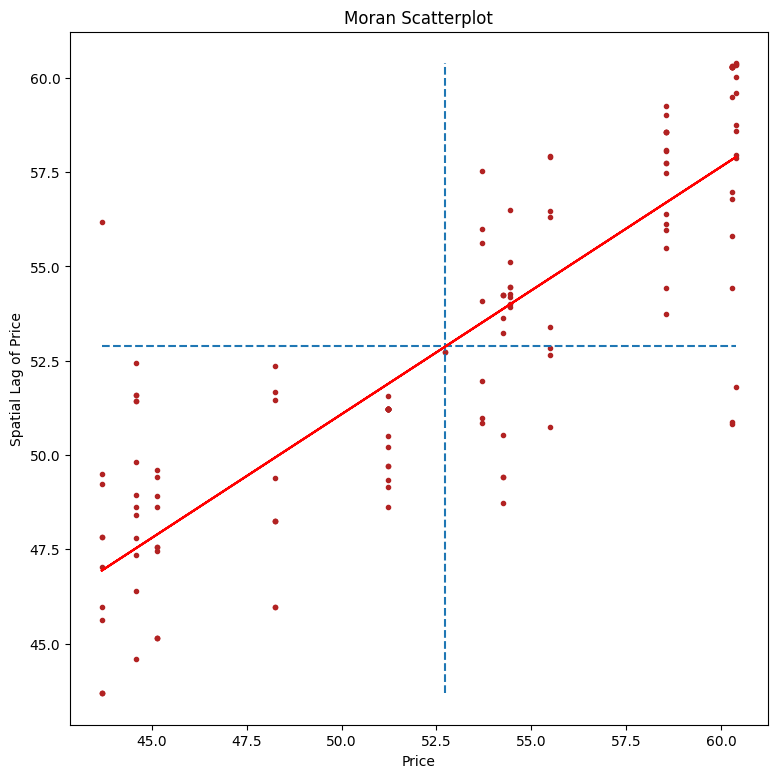

In [ ]:
# we'll visualize this as a Moran scatterplot
## set up the plot
price = df["price_mean"]
b, a = numpy.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

## define the basic plot
plt.plot(price, lag_price, ".", color="firebrick")

## add lines showing the means, vertically and horizontally
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle="--")
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle="--")

## add a trent line using the global Moran's I as the slope
plt.plot(price, a + b * price, "r")
plt.title("Moran Scatterplot")
plt.ylabel("Spatial Lag of Price")
plt.xlabel("Price")
plt.show()

In [ ]:
# Ensure y is a float64 array -- it resolves an error in the original script
y = numpy.array(y, dtype=numpy.float64)

# Run the local Moran
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
    li = esda.moran.Moran_Local(y=y, w=weights)

# see some results
li.q

array([1, 1, 1, 3, 3, 4, 3, 3, 4, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 4, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 4, 3, 1,
       1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 4, 3, 4, 1, 3, 3, 3, 3, 3, 4, 3, 3,
       4, 1, 1, 1, 1, 2, 3, 3])

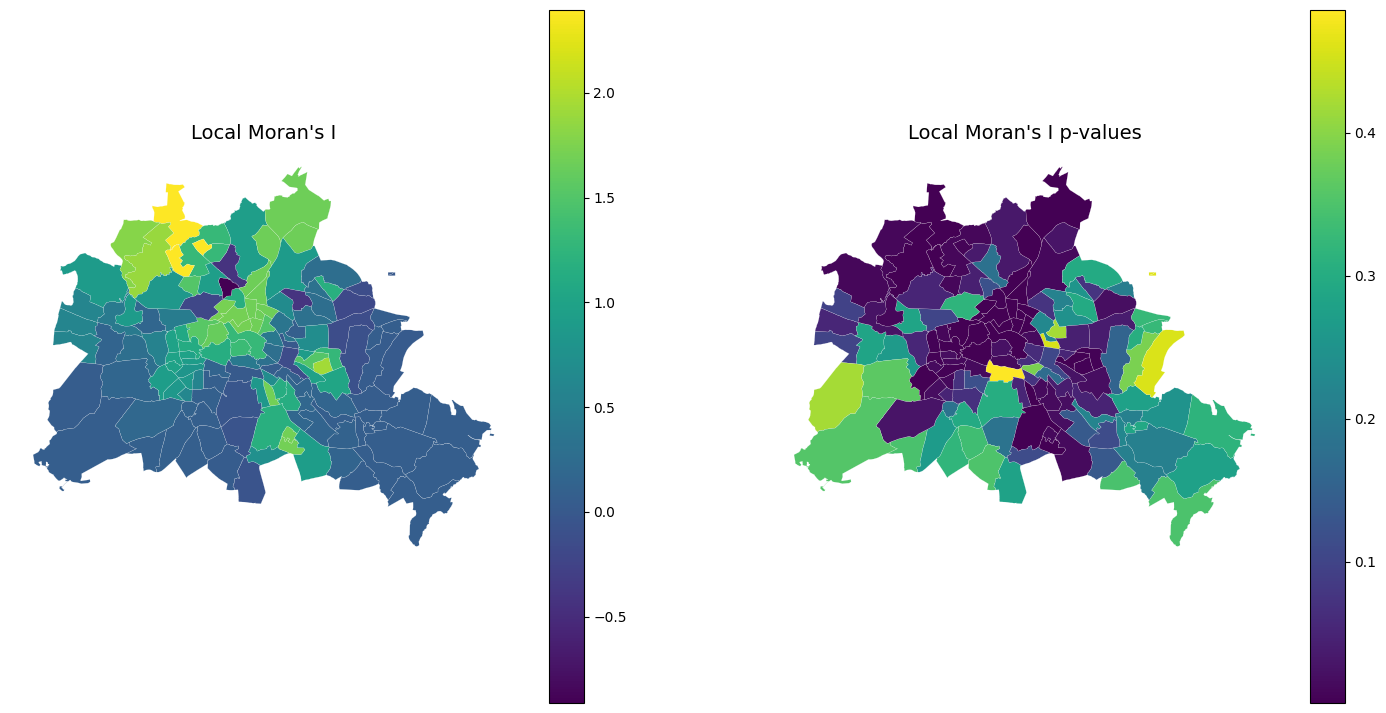

In [ ]:
# map the local Moran scores and p-values side-by-side

# initiate a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# plot 1: local Moran's I scores
df.plot(
    column=li.Is,
    cmap="viridis",
    linewidth=0.1,
    ax=axs[0], # chooses the first subplot
    edgecolor="white",
    legend=True,
)
axs[0].set_title("Local Moran's I", fontsize=14)
axs[0].set_axis_off()

# plot 2: pseudo p-values
df.plot(
    column=li.p_sim,
    cmap="viridis",
    linewidth=0.1,
    ax=axs[1], # chooses the second subplot
    edgecolor="white",
    legend=True,
)
axs[1].set_title("Local Moran's I p-values", fontsize=14)
axs[1].set_axis_off()

plt.show()

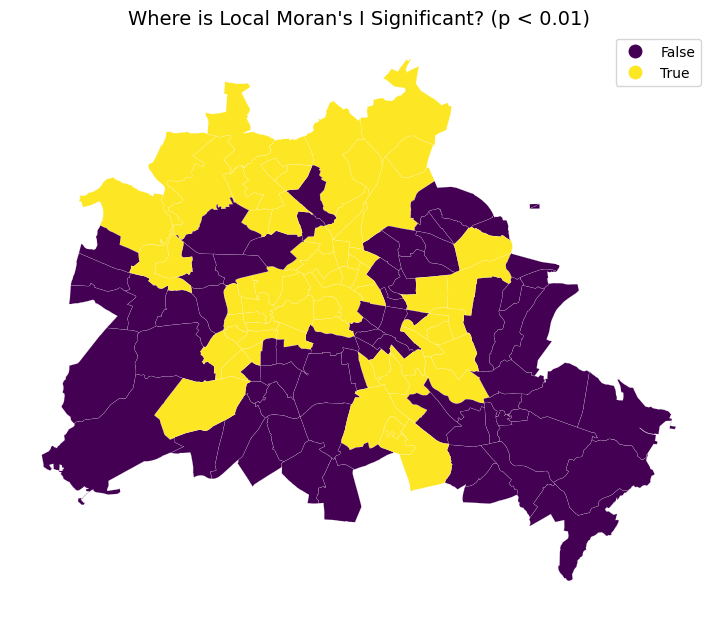

In [ ]:
# Now we'll visualize 'significant' local values
# create new columns to filter by significance level
df["significant"] = li.p_sim < 0.05

# Plot the map
fig, ax = plt.subplots(1, figsize=(9, 9))
df.plot(
    column="significant",
    cmap="viridis",
    linewidth=0.1,
    ax=ax,
    edgecolor="white",
    legend=True,
)
ax.set_title("Where is Local Moran's I Significant? (p < 0.01)", fontsize=14)
ax.set_axis_off()
plt.show()

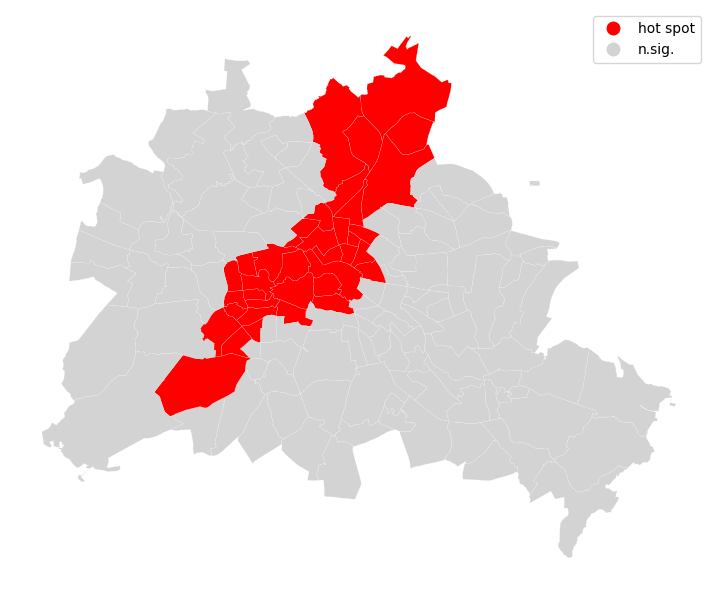

In [ ]:
# hot spots
# create a hot spot variable
sig = li.p_sim < 0.05
hotspot = sig * li.q == 1
spots = ["n.sig.", "hot spot"]
labels = [spots[i] for i in hotspot * 1]

# map it
hmap = colors.ListedColormap(["red", "lightgrey"])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap=hmap,
    linewidth=0.1,
    ax=ax,
    edgecolor="white",
    legend=True,
)
ax.set_axis_off()
plt.show()

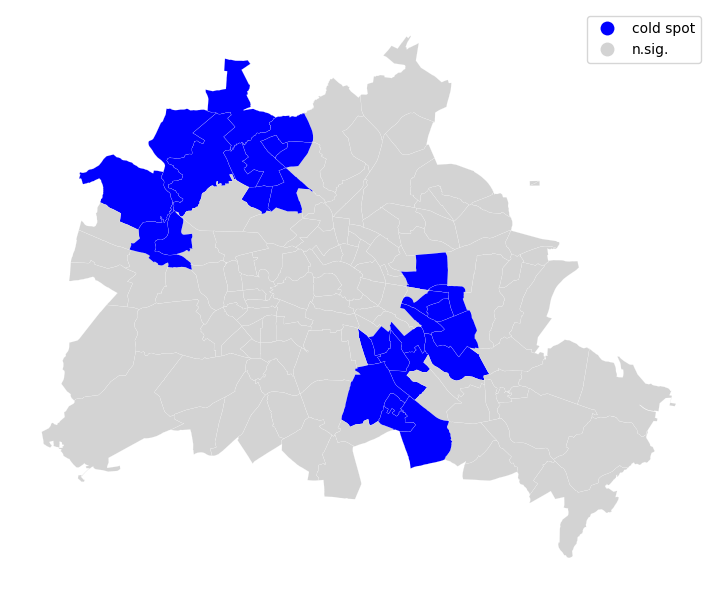

In [ ]:
# cold spots
# create a cold spot variable
sig = li.p_sim < 0.05
coldspot = sig * li.q == 3
spots = ["n.sig.", "cold spot"]
labels = [spots[i] for i in coldspot * 1]

# now map it
hmap = colors.ListedColormap(["blue", "lightgrey"])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap=hmap,
    linewidth=0.1,
    ax=ax,
    edgecolor="white",
    legend=True,
)
ax.set_axis_off()
plt.show()

# Bivariate Moran's I
The global and local versions of Moran's I test for _autocorrelation_ within a single variable. But often, we want to understand not only if a variable is clustered, but if it is clustered and correlated with other variables.

Bivariate Moran's I is one way to assess this. For the tests that follow, we'll explore correlation between `price_mean` and `reviews_per_month`. We'll calculate both a global and local version of the bivariate Moran's I.

In [ ]:
# summarize a second variable by neighborhood
mean_reviews_gb = spatialjoin["reviews_per_month"].groupby([spatialjoin["neighbourhood_group"]]).mean()
mean_reviews_gb

,reviews_per_month
neighbourhood_group,
Charlottenburg-Wilm.,1.186605
Friedrichshain-Kreuzberg,1.044028
Lichtenberg,1.194613
Marzahn - Hellersdorf,1.150328
Mitte,1.354240
Neukölln,0.815404
Pankow,1.020019
Reinickendorf,1.198354
Spandau,0.849538


In [ ]:
# join back to boundary data
df = df.join(mean_reviews_gb, on="neighbourhood_group")
df.rename(columns={"reviews_per_month": "reviews_mean"}, inplace=True)

df

,neighbourhood,neighbourhood_group,geometry,price_mean,lag_price_mean,significant,reviews_mean
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",60.282516,56.962506,True,1.020019
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",60.282516,60.282516,True,1.020019
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...",58.556408,56.377499,False,1.186605
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.3963, 13.70926 52....",51.222004,51.222004,False,0.926136
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.4085, 13.73773 52....",51.222004,51.222004,False,0.926136
...,...,...,...,...,...,...,...
135,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52...",54.246754,54.246754,False,1.150328
136,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52...",54.246754,53.238504,False,1.150328
137,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52...",43.682465,56.185190,False,1.198354
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52...",43.682465,49.233377,True,1.198354


In [ ]:
# set up a new data frame by excluding nulls
df_cleaned = df.dropna(subset=["price_mean", "reviews_mean"]).copy()
df_cleaned

,neighbourhood,neighbourhood_group,geometry,price_mean,lag_price_mean,significant,reviews_mean
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",60.282516,56.962506,True,1.020019
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",60.282516,60.282516,True,1.020019
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...",58.556408,56.377499,False,1.186605
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.3963, 13.70926 52....",51.222004,51.222004,False,0.926136
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.4085, 13.73773 52....",51.222004,51.222004,False,0.926136
...,...,...,...,...,...,...,...
135,Hellersdorf-Ost,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.62135 52.52704, 13.62079 52...",54.246754,54.246754,False,1.150328
136,Mahlsdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.65554 52.52982, 13.65693 52...",54.246754,53.238504,False,1.150328
137,Ost 1,Reinickendorf,"MULTIPOLYGON (((13.36666 52.55823, 13.36561 52...",43.682465,56.185190,False,1.198354
138,Ost 2,Reinickendorf,"MULTIPOLYGON (((13.36418 52.56298, 13.36423 52...",43.682465,49.233377,True,1.198354


In [ ]:
# use a queen contiguity for the matrix
weights_cleaned = lps.weights.Queen.from_dataframe(df_cleaned, use_index=False, silence_warnings=True)

# tranform the weights so they are standardized by row
# that is, the weights for each row will sum to 1
weights_cleaned.transform = "r"
weights_cleaned

Now we'll test the global bivariate Moran's I. The hypotheses for a test like this are:
> H0: Both variables are spatially random, and they are not correlated to each other.

> HA: One or both variables have an underlying spatial structure, and they are correlated to each other.

In [ ]:
# global bivariate Moran's I
bivariate_mi = esda.moran.Moran_BV(x=df_cleaned['price_mean'],
                                   y=df_cleaned['reviews_mean'],
                                   w=weights_cleaned)

# show results
print(f"Bivariate Moran's I: {bivariate_mi.I}")
print(f"pseudo p-value: {bivariate_mi.p_sim}")

Bivariate Moran's I: 0.23813140785800427
pseudo p-value: 0.001


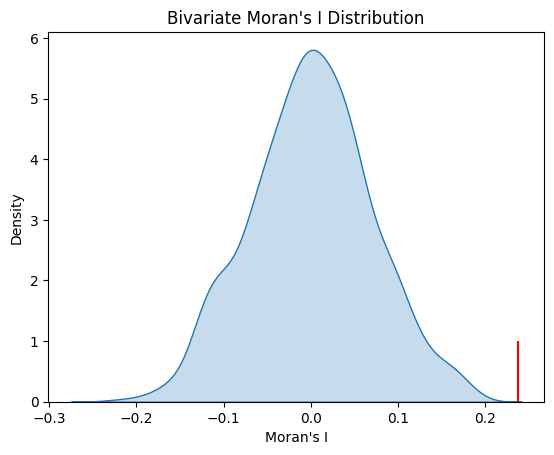

In [ ]:
# visualize it relative to simulated values
seaborn.kdeplot(bivariate_mi.sim, fill=True)
plt.vlines(bivariate_mi.I, 0, 1, color="r")  # adds the observed mi.I
plt.xlabel("Moran's I")
plt.ylabel("Density")
plt.title("Bivariate Moran's I Distribution")
plt.show()

And this will run the local version of the bivariate Moran's I. For this test, we go through the observations pair-by-pair following the spatial weights matrix. For each pairing, the spatial lag is assessed for each individual variable (`price_mean` and `reviews_mean`) to assess spatial structure. And then the relationship between those two variables (again filtered through the weights matrix) is also assessed with a correlation coefficient.

In [ ]:
# Run the local Moran
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
    bivariate_li = esda.moran.Moran_Local_BV(x=df_cleaned['price_mean'],
                                             y=df_cleaned['reviews_mean'],
                                             w=weights_cleaned)

# see some results
bivariate_li.q

array([4, 4, 1, 3, 3, 1, 2, 3, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 4,
       1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       1, 3, 3, 4, 4, 3, 3, 4, 3, 3, 4, 4, 4, 1, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 2, 2, 3, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
       1, 1, 3, 3, 4, 4, 1, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1,
       1, 1, 1, 2, 2, 2])

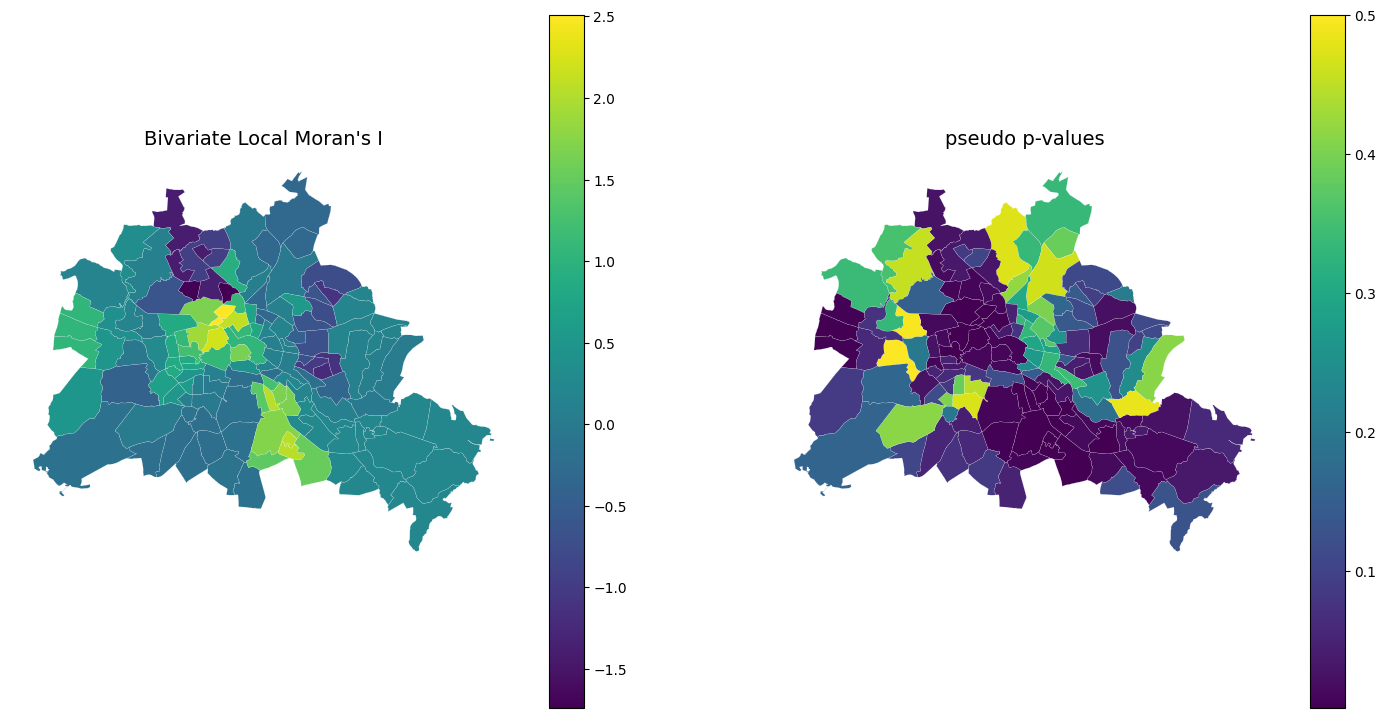

In [ ]:
# map the bivariate local Moran scores and p-values side-by-side

# initiate a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# plot 1: local Moran's I scores
df_cleaned.plot(
    column=bivariate_li.Is,
    cmap="viridis",
    linewidth=0.1,
    ax=axs[0], # chooses the first subplot
    edgecolor="white",
    legend=True,
)
axs[0].set_title("Bivariate Local Moran's I", fontsize=14)
axs[0].set_axis_off()

# plot 2: pseudo p-values
df_cleaned.plot(
    column=bivariate_li.p_sim,
    cmap="viridis",
    linewidth=0.1,
    ax=axs[1], # chooses the second subplot
    edgecolor="white",
    legend=True,
)
axs[1].set_title("pseudo p-values", fontsize=14)
axs[1].set_axis_off()

plt.show()

# Further reading
Anselin, Luc (2023) _An Introduction to Spatial Data Science Using GeoDa_. Chapter 13: Spatial Autocorrelation: https://lanselin.github.io/introbook_vol1/CHglobalsa.html

Anselin, Luc (2023) _An Introduction to Spatial Data Science Using GeoDa_. Chapter 16: LISA and Local Moran: https://lanselin.github.io/introbook_vol1/CHLISA.html

Anselin, Luc (2023) _An Introduction to Spatial Data Science Using GeoDa_. Chapter 18: Multivariate Local Spatial Autocorrelation: https://lanselin.github.io/introbook_vol1/CHmultilisa.html

Wolf, Levi & Rey, Serge, _Exploratory Analysis of Spatial Data: Spatial Autocorrelation. https://pysal.org/esda/notebooks/spatial_autocorrelation_for_areal_unit_data.html#